$$
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\E}{\mathbb E}
\newcommand{\R}{\mathbb R}
$$

<!-- SOLUTION CELL -->
<h2 style="color: red">This is the solutions file!</h2>

<span style="color: red">We strongly recommend not looking at this file, which contains the solutions to all the exercises, until after the practical is over. Use [`practical.ipynb`](practical.ipynb) instead.</span>

In [1]:
# SOLUTION CELL
# This is put straight into practical.ipynb so it renders untrusted...
from IPython.display import display, Markdown
with open('README-setup.md') as f:
    display(Markdown(f.read()))

This notebook is the practical component of the [Data Science Summer School](https://www.ds3-datascience-polytechnique.fr) 2019 session on "Learning With Positive Definite Kernels: Theory, Algorithms, and Applications."

It was prepared primarily by [Dougal Sutherland](http://www.gatsby.ucl.ac.uk/~dougals/), based on discussions with [Bharath Sriperumbudur](http://personal.psu.edu/bks18/), and partially based on earlier [materials](https://github.com/karlnapf/ds3_kernel_testing) by [Heiko Strathmann](http://herrstrathmann.de/).

We'll cover, in varying levels of detail, the following topics:

- Solving regression problems with kernel ridge regression:
  - The "standard" approach.
  - Computational/statistical tradeoffs using the Nyström and random Fourier kernel approximations.
  - Learning an appropriate kernel function in a meta-learning setting.
- Two-sample testing with the kernel Maximum Mean Discrepancy (MMD):
  - Estimators for the MMD.
  - Learning an appropriate kernel function.

## Dependencies

### Colab

This notebook is available on Google Colab (**XXX: link**). You don't have to set anything up yourself and it runs on cloud resources, so this is probably the easiest option.


### Files
There are a few Python files and some data files in the repository. By far the easiest thing to do is just put them all in the same directory:

```
git clone https://github.com/dougalsutherland/ds3-kernels
```

#### Python version
This notebook requires Python 3.6+. Python 3.0 was released in 2008, and it's time to stop living in the past; most importart Python projects [are dropping support for Python 2 this year](https://python3statement.org/). If you've never used Python 3 before, don't worry! It's almost the same; for the purposes of this notebook, you probably only need to know that you should write `print("hi")` since it's a function call now, and you can write `A @ B` instead of `np.dot(A, B)`.

#### Python packages

The main thing we use is PyTorch and Jupyter. If you already have those set up, you should be fine; just additionally make sure you also have (with `conda install` or `pip install`) `seaborn`, `tqdm`, and `sckit-learn`. We import everything right at the start, so if that runs you shouldn't hit any surprises later on.

If you don't already have a setup you're happy with, we recommend the `conda` package manager - start by installing [miniconda](https://docs.conda.io/en/latest/miniconda.html). Then you can create an environment with everything you need as:

```bash
conda create --name ds3-kernels \
  --override-channels -c pytorch -c defaults --strict-channel-priority \
  python=3 notebook \
  numpy scipy scikit-learn \
  pytorch=1.1 torchvision \
  matplotlib seaborn tqdm

conda activate ds3-kernels

git clone https://github.com/dougalsutherland/ds3-kernels
cd ds3-kernels
jupyter notebook
```

(If you have an old conda setup, you can use `source activate` instead of `conda activate`, but it's better to [switch to the new style of activation](https://conda.io/projects/conda/en/latest/release-notes.html#recommended-change-to-enable-conda-in-your-shell). This won't matter for this tutorial, but it's general good practice.)

(You can make your life easier when using jupyter notebooks with multiple kernels by installing `nb_conda_kernels`, but as long as you install and run `jupyter` from inside the env it will also be fine.)


## PyTorch

We're going to use PyTorch in this tutorial, even though we're not doing a ton of "deep learning." (The CPU version will be fine, though a GPU might let you get slightly better performance in some of the "advanced" sections.)

If you haven't used PyTorch before, don't worry! The API is unfortunately a little different from NumPy (and TensorFlow), but it's pretty easy to get used to; you can refer to [a cheat sheet vs NumPy](https://github.com/wkentaro/pytorch-for-numpy-users/blob/master/README.md) as well as the docs: [tensor methods](https://pytorch.org/docs/stable/tensors.html) and [the `torch` namespace](https://pytorch.org/docs/stable/torch.html#torch.eq). Feel free to ask if you have trouble figuring something out.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook')

import functools

import numpy as np
from sklearn.model_selection import train_test_split
import torch

from ds3_support import as_tensors, LazyKernel

# download some datasets
from torchvision.datasets import MNIST, Omniglot
MNIST(root='data', download=True)
Omniglot(root='data', download=True)

Files already downloaded and verified


Dataset Omniglot
    Number of datapoints: 19280
    Root location: data/omniglot-py

## Ridge regression
Okay, time to get going.

We're going to start with implementing kernel ridge regression. First, here's a toy dataset to test your code on:

In [3]:
# SOLUTION CELL
from sklearn.metrics.pairwise import rbf_kernel

def make_toy(n_pts, dist_seed=17, samp_seed=12):
    drs = np.random.RandomState(seed=dist_seed)
    inducing = drs.uniform(0, 1, size=50)
    w = drs.normal(size=inducing.shape[0])
    
    srs = np.random.RandomState(seed=samp_seed)
    X = srs.uniform(0, 1, size=n_pts)
    ymean = rbf_kernel(X[:, None], inducing[:, None], gamma=1 / (2 * .05**2)) @ w
    y = ymean + srs.normal(scale=.1, size=ymean.shape)
    return X[:, None].astype(np.float32), y.astype(np.float32)

X, y = make_toy(500)
np.savez('data/ridge-toy.npz', X=X, y=y)

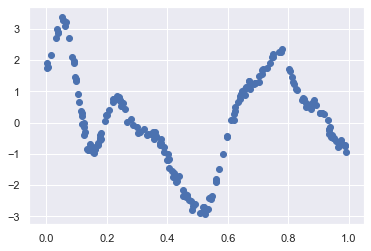

In [4]:
with np.load('data/ridge-toy.npz') as f:
    toy_X = f['X']
    toy_y = f['y']
toy_X_train, toy_X_test, toy_y_train, toy_y_test = train_test_split(
    toy_X, toy_y, train_size=200)

fig, ax = plt.subplots()
ax.scatter(toy_X_train[:, 0], toy_y_train)

This data looks like it could be well-modeled by a Gaussian RBF kernel. We'll need a fairly small bandwidth. See the minimum a little above 0.15 and the maximum a little less than 0.25? The Gaussian kernel still has a fair amount of influnce one bandwidth away, so we want to make the bandwidth a little smaller than that; say 0.05. So, first let's implement the kernel.

<sup>I totally eyeballed that like I said, and definitely didn't just generate the true function in the first place from an RBF function with that bandwidth....</sup>

### Kernels

So, first, let's implement an RBF kernel first. I've put some helper infrastructure in the `LazyKernel` class (in [`ds3_support.kernels`](ds3_support/kernels.py)) that will be especially useful later; for now, it's just a way to organize computing it. Here's an example of how to use it:

In [5]:
class LinearKernel(LazyKernel):
    def _compute(self, A, B):
        return A @ B.t()

The `_compute` method computes the kernel between two inputs `A` and `B`. (`.t()` is PyTorch for taking a transpose; `@` is the nifty Python 3.6+ syntax for matrix multiplication.)

The `LazyKernel` base class lets us use this in various ways. First, to find the kernel from one set of points to another:

In [7]:
K = LinearKernel(toy_X_train, toy_X_test)
print(K)
K.XY

<LinearKernel(200, 300)>


tensor([[8.8594e-01, 6.8067e-01, 5.3862e-01,  ..., 4.5821e-01, 2.2200e-01,
         7.6313e-01],
        [3.2720e-03, 2.5139e-03, 1.9892e-03,  ..., 1.6923e-03, 8.1990e-04,
         2.8184e-03],
        [5.5697e-01, 4.2792e-01, 3.3862e-01,  ..., 2.8807e-01, 1.3957e-01,
         4.7976e-01],
        ...,
        [8.5458e-01, 6.5657e-01, 5.1955e-01,  ..., 4.4199e-01, 2.1414e-01,
         7.3611e-01],
        [9.5230e-01, 7.3165e-01, 5.7896e-01,  ..., 4.9253e-01, 2.3863e-01,
         8.2029e-01],
        [2.6384e-01, 2.0271e-01, 1.6040e-01,  ..., 1.3646e-01, 6.6114e-02,
         2.2727e-01]])

You can also get the X-to-X (`XX`) and Y-to-Y (`YY`) kernel matrices from the same object (which are the result of `_compute(X, X)` and `_compute(Y, Y)`). These aren't computed until you need them, but then they're cached after you use them the first time; this is why it's a `LazyKernel`.

In [8]:
K.XX

tensor([[7.9258e-01, 2.9272e-03, 4.9828e-01,  ..., 7.6452e-01, 8.5194e-01,
         2.3604e-01],
        [2.9272e-03, 1.0811e-05, 1.8402e-03,  ..., 2.8236e-03, 3.1464e-03,
         8.7174e-04],
        [4.9828e-01, 1.8402e-03, 3.1325e-01,  ..., 4.8063e-01, 5.3559e-01,
         1.4839e-01],
        ...,
        [7.6452e-01, 2.8236e-03, 4.8063e-01,  ..., 7.3746e-01, 8.2178e-01,
         2.2768e-01],
        [8.5194e-01, 3.1464e-03, 5.3559e-01,  ..., 8.2178e-01, 9.1575e-01,
         2.5372e-01],
        [2.3604e-01, 8.7174e-04, 1.4839e-01,  ..., 2.2768e-01, 2.5372e-01,
         7.0294e-02]])

If you only want the kernel matrix for a dataset to itself, you can just not pass the second argument. Then K.XY won't exist.

In [8]:
LinearKernel(toy_X_train).XX

tensor([[5.1041e-06, 1.6957e-03, 1.0986e-05,  ..., 3.9768e-04, 1.9894e-03,
         1.4836e-04],
        [1.6957e-03, 5.6335e-01, 3.6498e-03,  ..., 1.3212e-01, 6.6091e-01,
         4.9288e-02],
        [1.0986e-05, 3.6498e-03, 2.3646e-05,  ..., 8.5596e-04, 4.2818e-03,
         3.1932e-04],
        ...,
        [3.9768e-04, 1.3212e-01, 8.5596e-04,  ..., 3.0985e-02, 1.5500e-01,
         1.1559e-02],
        [1.9894e-03, 6.6091e-01, 4.2818e-03,  ..., 1.5500e-01, 7.7537e-01,
         5.7823e-02],
        [1.4836e-04, 4.9288e-02, 3.1932e-04,  ..., 1.1559e-02, 5.7823e-02,
         4.3122e-03]])

Alternatively, you can pass `None`, which is a special value meaning "use the first one." Then `XY` and so on will exist, but it knows to cache them appropriately.

You can also pass three arguments; then there'll be `XZ`, etc. You can also access them with e.g. `K[0, 2]`.

In [9]:
K = LinearKernel(toy_X_train, None, toy_X_test)
print(K)
K.YZ

<LinearKernel(200, 200, 300)>


tensor([[8.5273e-04, 2.0791e-03, 7.7852e-04,  ..., 1.1590e-03, 3.1319e-05,
         1.2660e-03],
        [2.8329e-01, 6.9071e-01, 2.5864e-01,  ..., 3.8505e-01, 1.0405e-02,
         4.2059e-01],
        [1.8354e-03, 4.4749e-03, 1.6757e-03,  ..., 2.4946e-03, 6.7409e-05,
         2.7249e-03],
        ...,
        [6.6439e-02, 1.6199e-01, 6.0658e-02,  ..., 9.0304e-02, 2.4402e-03,
         9.8638e-02],
        [3.3236e-01, 8.1033e-01, 3.0343e-01,  ..., 4.5174e-01, 1.2207e-02,
         4.9343e-01],
        [2.4786e-02, 6.0431e-02, 2.2629e-02,  ..., 3.3688e-02, 9.1032e-04,
         3.6798e-02]])

Here's an example of a slightly more complex kernel class, with some parameters:

In [10]:
class PolynomialKernel(LazyKernel):
    def __init__(self, X, *rest, degree=3, gamma=None, coef0=1):
        super().__init__(X, *rest)
        self.degree = degree
        self.gamma = 1 / X.shape[1] if gamma is None else gamma
        self.coef0 = coef0

    def _compute(self, A, B):
        XY = A @ B.t()
        return (self.gamma * XY + self.coef0) ** self.degree

You also totally don't need to do this – you definitely won't notice the difference on this scale of data – but if you want to cache some computation for each dataset, you can use the `_precompute` interface. You can return a list of cached information in `_precompute`, which then get passed to `_compute` as `_compute(A, *A_precomputed, B, *B_precomputed)`.

In [11]:
class LinearAndSquareKernel(LazyKernel):
    def _precompute(self, A):
        return [A * A]
    
    def _compute(self, A, A_squared, B, B_squared):
        return A @ B.t() + A_squared @ B_squared.t()

Remember that the Gaussian RBF kernel is
$$k(x, y) = \exp\left( -\frac{1}{2 \sigma^2} \lVert x - y \rVert^2 \right).$$
Go ahead and implement that here. It might be helpful to recall that
$$\lVert x - y \rVert^2 = \lVert x \rVert^2 + \lVert y \rVert^2 - 2 x^T y.$$

In [12]:
class RBFKernel(LazyKernel):
    def __init__(self, *parts, sigma=1):
        super().__init__(*parts)
        self.sigma = sigma
    
    # TODO: implement _compute (maybe with _precompute)
    def _precompute(self, A):                                            # SOLUTION
        # Squared norms of each data point                               # SOLUTION
        return [torch.einsum("ij,ij->i", A, A)]                          # SOLUTION
                                                                         # SOLUTION
    def _compute(self, A, A_sqnorms, B, B_sqnorms):                      # SOLUTION
        D2 = A_sqnorms[:, None] + B_sqnorms[None, :] - 2 * (A @ B.t())   # SOLUTION
        return torch.exp(D2 / (-2 * self.sigma ** 2))                    # SOLUTION

You can check your implementation against scikit-learn's implementation (but it doesn't work in PyTorch, so don't just use it directly):

In [13]:
sigma = np.random.lognormal()
K = RBFKernel(toy_X_train, toy_X_test, sigma=sigma)

from sklearn.metrics.pairwise import rbf_kernel
gamma = 1 / (2 * sigma**2)  # sklearn uses this parameterization
assert np.allclose(K.XX.numpy(), rbf_kernel(toy_X_train, gamma=gamma))
assert np.allclose(K.XY.numpy(), rbf_kernel(toy_X_train, toy_X_test, gamma=gamma))
assert np.allclose(K.YY.numpy(), rbf_kernel(toy_X_test, gamma=gamma))

del rbf_kernel

### Implementing ridge regression

Okay, now we can compute all kinds of kernels; let's actually use them for something. First, let's implement ridge regression. Remember that ridge regression is
$$
  \min_{f \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^n \lVert f(X_i) - y_i \rVert^2 + \frac12 \lambda \lVert f \rVert_{\mathcal{H}}^2 
.$$
The representer theorem tells us that $f(x) = \sum_{i=1}^n \alpha_i k(X_i, x)$,
and then some calculus gives us
$$\alpha = (K + n \lambda I)^{-1} y, \tag{*}$$
where $K_{ij} = k(X_i, X_j)$.

There's also one more wrinkle: we're going to need to compute ridge regression for multiple outputs $y$ at once with the same $X$s. This just means solving the linear system for more than one $y$ at once; most software, including PyTorch, supports this built-in.

To implement $\textrm{(*)}$, there are (at least) two approaches.

- [`torch.solve`](https://pytorch.org/docs/stable/torch.html#torch.solve) is a general-purpose matrix solver, which uses an [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition). This doesn't exploit the special structure of kernel matrices (namely that they're [positive-definite](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix)).

- You could also use a [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_factorization), which is the standard approach for positive-definite matrices, and will be somewhat faster. You could implement this with [`torch.cholesky`](https://pytorch.org/docs/stable/torch.html#torch.cholesky) and [`torch.cholesky_solve`](https://pytorch.org/docs/stable/torch.html#torch.cholesky_solve) – but unfortunately PyTorch hasn't implemented derivatives through `cholesky_solve` yet, and we're going to need that later. You can use [`torch.triangular_solve`](https://pytorch.org/docs/stable/torch.html#torch.triangular_solve) instead; Cholesky gives us $L$ such that $K + n \lambda I = L L^T$, so you'll want $\alpha = (L L^T)^{-1} y = L^{-T} (L^{-1} y)$. (Make sure to pass `upper=False` to `triangular_solve`.)

In [14]:
class KernelRidgeRegression:
    def __init__(self, reg_wt=1):
        """
        reg_wt: The regularization weight lambda.
        """
        self.reg_wt = reg_wt
    
    def fit(self, K_XX, y):
        """
        Fit the ridge regression:
        
          K_XX: The training kernel matrix, of shape [n_train, n_train].
          y: The training labels, of shape [n_train] or [n_train, n_labels].        
        """
        K_XX, y = as_tensors(K_XX, y)
        
        assert len(K_XX.shape) == 2
        self.n_train = K_XX.shape[0]
        
        if len(y.shape) == 1:
            self.n_labels = None
            y = y[:, None]
        else:
            assert len(y.shape) == 2
            self.n_labels = y.shape[1]

        assert K_XX.shape[1] == y.shape[0] == self.n_train
        
        # TODO: find the solution, and save it in self.alpha or somewhere like that
        to_inv = K_XX + self.reg_wt * torch.eye(K_XX.shape[0])          # SOLUTION
        if getattr(self, '_solve_lu', False):                           # SOLUTION
            # the LU-based solution                                     # SOLUTION
            self.alpha = torch.solve(y, to_inv)[0]                      # SOLUTION
        else:                                                           # SOLUTION
            # the cholesky solution (default)                           # SOLUTION
            L = torch.cholesky(to_inv, upper=False)                     # SOLUTION
            inner = torch.triangular_solve(y, L, upper=False).solution  # SOLUTION
            self.alpha = torch.triangular_solve(                        # SOLUTION
                inner, L, upper=False, transpose=True).solution         # SOLUTION
    
    def predict(self, K_test):
        """
        Predict the labels of a test set.
        
          K_test: The train-to-test kernel matrix, shape [n_train, n_test].
        
        Return: the vector of test predictions, shape [n_test].
        """
        K_test = torch.as_tensor(K_test)
        assert len(K_test.shape) == 2
        assert K_test.shape[0] == self.n_train
        
        # TODO: set preds to shape [n_test, n_labels]
        preds = K_test.t() @ self.alpha     # SOLUTION
        
        # return a vector if we were fit with a vector, matrix otherwise
        return preds.squeeze(1) if self.n_labels is None else preds
    
    def mses(self, K_test, truth):
        """
        Returns the mean squared error of predictions on a test set.
        
          K_test: The train-to-test kernel matrix, shape [n_train, n_test].
          truth: The test labels, shape [n_test] or [n_test, n_labels].
        
        Returns a scalar if fit with a vector,
        or a vector of MSEs per label if fit with a matrix.
        """
        preds = self.predict(K_test)
        truth = torch.as_tensor(truth).reshape(preds.shape)
        return ((preds - truth) ** 2).mean(0)
    
    def mse(self, K_test, truth):
        """
        Returns the mean of mean-squared-errors across each label.
        """
        return self.mses(K_test, truth).mean()

Does it work?

In [15]:
def evaluate(krr, plot=True):
    plot_xs = np.linspace(0, 1, num=500)[:, None]
    K = RBFKernel(toy_X_train, toy_X_test, plot_xs, sigma=.05)

    krr.fit(K.XX, toy_y_train)
    train_mse = krr.mse(K.XX, toy_y_train).item()
    test_mse = krr.mse(K.XY, toy_y_test).item()
    
    if plot:
        fig, ax = plt.subplots()
        ax.scatter(toy_X_train[:, 0], toy_y_train)
        ax.plot(plot_xs, krr.predict(K.XZ).numpy(), lw=4, color='r')
        ax.set_title(f"Train MSE: {train_mse:.2} / Test MSE: {test_mse:.2}")
    else:
        return train_mse, test_mse

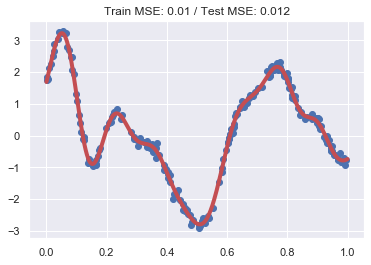

In [16]:
evaluate(KernelRidgeRegression(reg_wt=.1))
plt.savefig('figs/toy-krr-eval.png')  # SOLUTION

Here's what my solution looks like:
![hi](figs/toy-krr-eval.png)

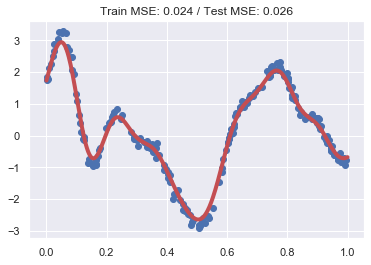

In [17]:
# SOLUTION CELL
# Check that the LU solve also works; should be almost identical.
krr = KernelRidgeRegression(reg_wt=1)
krr._solve_lu = True
evaluate(krr)

### A harder problem

Okay, that problem was too easy. 

## Hypothesis testing with MMD

## Advanced ridge regression: Meta-learning